In [4]:
import numpy as np
import random
import csv

data = []

# Betöltés
with open('data.csv','r', encoding="utf-8") as f:
    csvreader = csv.DictReader(f)
    for item in csvreader:
        data.append([ item['DATE'], item['AUTHOR'], item['CONTENT'], item['CLASS'] ])

# A 'data' tömb elemei: ['dátum string', 'szerző', 'komment', 'osztály cimke ('0': nem spam, '1': spam)']
        
# Train/test szétválasztás
split = 0.7
data = np.asarray(data)
perm = np.random.permutation(len(data))

train = data[perm][0:int(len(data)*split)]
test = data[perm][int(len(data)*split):]

print('Train set: ', np.shape(train))
print('Test set: ', np.shape(test))

# Buta osztályozó
def dumb_classify(data):
    threshold = 0.3
    if random.random() > threshold:
        return '1'
    else:
        return '0'


# Használd a 'train' adatokat az osztályozó módszer kidolgozására, a 'test' adatokat kiértékelésére!
# Lehetőleg használj gépi tanulást!
# Dokumentáld az érdekesnek tartott kísérleteket is!

# Példa kiértékelés 'recall' számításával. 
# Kérdés: Milyen egyéb metrikát használnál kiértékelésre és miért? 

# Kibővítve

sum_positive = 0
# True Positive
found_positive = 0
sum_negative = 0
# True Negative
found_negative = 0

false_negative = 0
false_positive = 0

for datapoint in test:
    if datapoint[-1] == '1':
        sum_positive += 1
        if dumb_classify(datapoint) == '1':
            found_positive += 1
        else:
            false_negative += 1
    else:
        sum_negative += 1
        if dumb_classify(datapoint) == '0':
            found_negative += 1
        else:
            false_positive += 1
            
# A Recall megmutatja hogy az osztályozó mekkora eséllyel ismeri fel a releváns elemeket   
rnd_rec = found_positive / sum_positive
print('\nRecall:', rnd_rec)

# Egyéb metrika:

# Precision
# Ez a metrika mutatja hogy az osztályozó mely esetekben ismerte fel helyesen a relevánsnak talált elemeket
rnd_prec = found_positive / (found_positive + false_positive)
print('Precision:', rnd_prec)

# F1 score
# Ez mutatja hogy milyen jól teljesít osztályozó az összes elemet figyelembe véve
rnd_f1 = 2 * (rnd_prec * rnd_rec) / (rnd_prec + rnd_rec)
print('F1 score:', rnd_f1 )

Train set:  (1367, 4)
Test set:  (586, 4)

Recall: 0.6860068259385665
Precision: 0.5012468827930174
F1 score: 0.579250720461095


# Első kísérlet: SVM

In [29]:
# X és y előállítása
# X a tanuló adatokat tartalmazza
# A nekünk fontos adat a kommentek szövege (CONTENT)
# y a klasszifikáció, jelen esetben hogy spam-e vagy nem (CLASS)


train_X = []
train_y = []
test_X = []
test_y = []

def loader(dataset, A, b, datarow, classrow):
    for item in dataset:
        A.append(item[datarow])
        b.append(item[classrow])
    
loader(train, train_X, train_y, 2, 3)
loader(test, test_X, test_y, 2, 3)

# SVM

from sklearn import metrics, svm
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# Pipeline segítségével összefűzhetjük a szükséges átalakításokat
# Jelen esetben a kommenteket fel kell bontani szavakra (tokenizálás) és ezeknek a szavaknak a vektorára van szükség
# Ezután megvizsgáljuk az egyes szavak gyakoriságát
# Az SVM ezek segítségével egy olyan modellt alkot meg ami azt vizsgálja, 
# hogy milyen szavak fordulnak elő gyakran a spam kommentekben

# A modell betanítása
def train_svm(kernel="linear"):
    model_pipeline = Pipeline([('cnts', CountVectorizer()),
                               ('tfidf', TfidfTransformer()),
                               ('clf', svm.SVC(kernel=kernel, random_state=42))])
    
    model_pipeline.fit(train_X, train_y)
    
    return model_pipeline

# A modell alkalmazása
# Itt a tanítóhalmazon betanított modellt alkalmazzuk a teszthalmazra
def test_svm(kernel="linear"):
    model = train_svm(kernel=kernel)
    predictions = model.predict(test_X)
    
    return predictions

# Metrikák
print(metrics.classification_report(test_y, test_svm("linear")))

             precision    recall  f1-score   support

          0       0.96      0.95      0.95       293
          1       0.95      0.96      0.95       293

avg / total       0.95      0.95      0.95       586



In [3]:
# Próbáljuk ki hogy az SVM segítségével a kommentelő neve szerint vizsgáljuk hogy spam-e valami
# Valószínűleg nincs erős összefüggés

train_X = []
train_y = []
test_X = []
test_y = []

loader(train, train_X, train_y, 1, 3)
loader(test, test_X, test_y, 1, 3)

print(metrics.classification_report(test_y, test_svm("linear")))

             precision    recall  f1-score   support

          0       0.50      0.83      0.63       272
          1       0.67      0.29      0.41       314

avg / total       0.59      0.54      0.51       586



# Második kísérlet: Többrétegű perceptron (MLP)

In [26]:
# Az MLP irányított gráfok összekapcsolt rétegeiből áll
# Jelen esetben egyetlen rejtett réteggel próbáljuk ki
# Ez a modell jobban paraméterezhető az SVM-nél és több mindent kipróbálhatunk

from sklearn.neural_network import MLPClassifier 

train_X = []
train_y = []
test_X = []
test_y = []

loader(train, train_X, train_y, 2, 3)
loader(test, test_X, test_y, 2, 3)

def train_mlp(bsize):
    model_pipeline = Pipeline([('cnts', CountVectorizer()),
                               ('tfidf', TfidfTransformer()),
                               ('clf', MLPClassifier(hidden_layer_sizes=100, activation="relu", solver="adam",
                                                    random_state=42, early_stopping=True, max_iter=1000,  
                                                     batch_size=bsize))])
    
    model_pipeline.fit(train_X, train_y)
    
    return model_pipeline

def test_mlp(bsize):
    model = train_mlp(bsize)
    predictions = model.predict(test_X)
    
    return predictions

def train_mlp2(funcact):
    model_pipeline = Pipeline([('cnts', CountVectorizer()),
                               ('tfidf', TfidfTransformer()),
                               ('clf', MLPClassifier(hidden_layer_sizes=100, activation=funcact, solver="adam",
                                                    random_state=42, early_stopping=True, max_iter=1000  
                                                     ))])
    
    model_pipeline.fit(train_X, train_y)
    
    return model_pipeline

def test_mlp2(funcact):
    model = train_mlp2(funcact)
    predictions = model.predict(test_X)
    
    return predictions
    
print(metrics.classification_report(test_y, test_mlp("auto")))

             precision    recall  f1-score   support

          0       0.97      0.88      0.92       293
          1       0.89      0.97      0.93       293

avg / total       0.93      0.92      0.92       586



In [41]:
# Vizsgáljuk meg a paramétereket

# A batch size valószínűleg csak a módszer sebességét befolyásolja, a pontosságot nem
# Itt kis számokra lassabb lesz
# A default érték min(200, n_samples)

print(metrics.classification_report(test_y, test_mlp(1)))

             precision    recall  f1-score   support

          0       0.96      0.97      0.97       282
          1       0.97      0.96      0.97       304

avg / total       0.97      0.97      0.97       586



In [42]:
print(metrics.classification_report(test_y, test_mlp(10)))

             precision    recall  f1-score   support

          0       0.92      0.98      0.95       282
          1       0.98      0.92      0.95       304

avg / total       0.95      0.95      0.95       586



In [43]:
print(metrics.classification_report(test_y, test_mlp(50)))

             precision    recall  f1-score   support

          0       0.94      0.97      0.96       282
          1       0.97      0.94      0.96       304

avg / total       0.96      0.96      0.96       586



In [44]:
print(metrics.classification_report(test_y, test_mlp(150)))

             precision    recall  f1-score   support

          0       0.93      0.96      0.95       282
          1       0.97      0.94      0.95       304

avg / total       0.95      0.95      0.95       586



In [52]:
# Következőnek kipróbálhatjuk az activation function cseréjét
# Ezt a függvényt használja a rejtett réteg

# Első lehetőség: Identity/Azonos f(x)=x

# Hasonló hatékonyságú az előzőekhez

print(metrics.classification_report(test_y, test_mlp2("identity")))

             precision    recall  f1-score   support

          0       0.96      0.93      0.94       282
          1       0.93      0.96      0.95       304

avg / total       0.95      0.95      0.95       586



In [53]:
# Logistic

# Rendkívül rossz recall-t ad

print(metrics.classification_report(test_y, test_mlp2("logistic")))

             precision    recall  f1-score   support

          0       1.00      0.05      0.09       282
          1       0.53      1.00      0.69       304

avg / total       0.76      0.54      0.40       586



In [54]:
# Tangens hiperbolikusz

# Ez is az eddigiekhez hasonlóan teljesít

print(metrics.classification_report(test_y, test_mlp2("tanh")))

             precision    recall  f1-score   support

          0       0.96      0.93      0.94       282
          1       0.93      0.96      0.95       304

avg / total       0.95      0.95      0.95       586



# Harmadik kísérlet: Random Forest

In [23]:
# A Random Forest módszer döntésfákat alkalmaz a tanítóadatok részhalmazaira

from sklearn.ensemble import RandomForestClassifier

# Paraméterek: 
# est - fák száma
# mf - részhalmaz méretezése
# md - döntésfák mélysége

def train_random_forest(est, mf, md):
    model_pipeline = Pipeline([('cnts', CountVectorizer()),
                               ('tfidf', TfidfTransformer()),
                               ('clf', RandomForestClassifier(random_state=42,
                                                             n_estimators=est, max_features=mf, max_depth=md))])
    
    model_pipeline.fit(train_X, train_y)
    
    return model_pipeline

def test_random_forest(est, mf, md):
    model = train_random_forest(est, mf, md)
    predictions = model.predict(test_X)
    
    return predictions
    
# Default értékek    
print(metrics.classification_report(test_y, test_random_forest(10, "auto", None)))

             precision    recall  f1-score   support

          0       0.91      0.96      0.93       293
          1       0.95      0.91      0.93       293

avg / total       0.93      0.93      0.93       586



In [59]:
# Kísérletezés a paraméterekkel

# Növeljük meg a fák számát:

print(metrics.classification_report(test_y, test_random_forest(20, "auto", None)))

print(metrics.classification_report(test_y, test_random_forest(30, "auto", None)))

print(metrics.classification_report(test_y, test_random_forest(50, "auto", None)))

print(metrics.classification_report(test_y, test_random_forest(100, "auto", None)))

# Úgy látszik egy pici javulást el lehet érni de egy értéken felül nem hasznos

             precision    recall  f1-score   support

          0       0.94      0.98      0.96       282
          1       0.98      0.94      0.96       304

avg / total       0.96      0.96      0.96       586

             precision    recall  f1-score   support

          0       0.94      0.98      0.96       282
          1       0.98      0.94      0.96       304

avg / total       0.96      0.96      0.96       586

             precision    recall  f1-score   support

          0       0.93      0.99      0.96       282
          1       0.99      0.93      0.96       304

avg / total       0.96      0.96      0.96       586

             precision    recall  f1-score   support

          0       0.94      0.98      0.96       282
          1       0.98      0.94      0.96       304

avg / total       0.96      0.96      0.96       586



In [61]:
# Max features tesztelése:

print(metrics.classification_report(test_y, test_random_forest(20, "log2", None)))

# Ez rosszabb recallhoz vezet

print(metrics.classification_report(test_y, test_random_forest(20, None, None)))

# "None" esetén 1%-al jobb mint default

             precision    recall  f1-score   support

          0       0.88      0.98      0.93       282
          1       0.98      0.88      0.93       304

avg / total       0.93      0.93      0.93       586

             precision    recall  f1-score   support

          0       0.93      0.98      0.95       282
          1       0.98      0.93      0.95       304

avg / total       0.95      0.95      0.95       586



In [67]:
# Fa mélység tesztelése:

print(metrics.classification_report(test_y, test_random_forest(20, "auto", 1)))

print(metrics.classification_report(test_y, test_random_forest(20, "auto", 2)))

print(metrics.classification_report(test_y, test_random_forest(20, "auto", 5)))

print(metrics.classification_report(test_y, test_random_forest(20, "auto", 10)))

print(metrics.classification_report(test_y, test_random_forest(20, "auto", 20)))

print(metrics.classification_report(test_y, test_random_forest(20, "auto", 40)))

print(metrics.classification_report(test_y, test_random_forest(20, "auto", 80)))

print(metrics.classification_report(test_y, test_random_forest(20, "auto", 150)))

print(metrics.classification_report(test_y, test_random_forest(20, "auto", 300)))

             precision    recall  f1-score   support

          0       0.68      0.91      0.78       282
          1       0.88      0.61      0.72       304

avg / total       0.78      0.75      0.75       586

             precision    recall  f1-score   support

          0       0.73      0.95      0.83       282
          1       0.94      0.67      0.79       304

avg / total       0.84      0.81      0.81       586

             precision    recall  f1-score   support

          0       0.78      0.96      0.86       282
          1       0.95      0.74      0.83       304

avg / total       0.87      0.85      0.85       586

             precision    recall  f1-score   support

          0       0.82      0.98      0.90       282
          1       0.98      0.81      0.88       304

avg / total       0.91      0.89      0.89       586

             precision    recall  f1-score   support

          0       0.84      0.97      0.90       282
          1       0.97      0.83 

In [71]:
# Próbáljuk ki hogy a nagy mélységet kombináljuk a "None" beállítású "Max Features"-el

print(metrics.classification_report(test_y, test_random_forest(20, None, 200)))

print(metrics.classification_report(test_y, test_random_forest(20, None, 300)))

print(metrics.classification_report(test_y, test_random_forest(20, None, 400)))

# Nem javít a korábbiakon

             precision    recall  f1-score   support

          0       0.93      0.98      0.95       282
          1       0.98      0.93      0.95       304

avg / total       0.95      0.95      0.95       586

             precision    recall  f1-score   support

          0       0.93      0.98      0.95       282
          1       0.98      0.93      0.95       304

avg / total       0.95      0.95      0.95       586

             precision    recall  f1-score   support

          0       0.93      0.98      0.95       282
          1       0.98      0.93      0.95       304

avg / total       0.95      0.95      0.95       586



# Vizualizáció

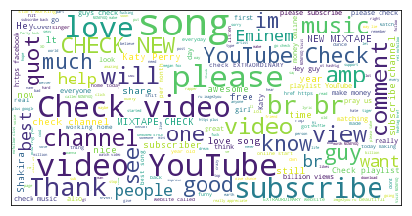

In [19]:
# Wordcloud

# https://github.com/amueller/word_cloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Szöveg

full_text = ""

for line in data:
    full_text += line[2]

# Rajz    
    
def generate_word_cloud(data):
    wc = WordCloud(background_color='white',
                   stopwords=STOPWORDS,
                   max_words=300,
                   max_font_size=40, 
                   random_state=42).generate(data)
    
    plt.figure(figsize=(7, 15))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wc)
    plt.show()
    
generate_word_cloud(full_text)

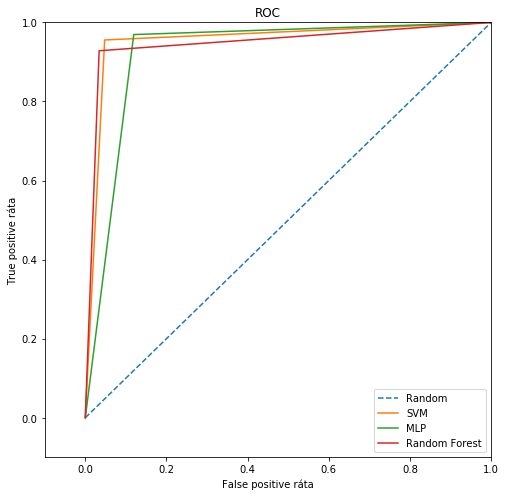

Modellek végső rangsora:
------------------------
1. SVM: ROC AUC = 0.9539249146757679
2. Random Forest: ROC AUC = 0.9470989761092151
3. MLP: ROC AUC = 0.9249146757679181


In [33]:
# Összehasonlítás

# ROC görbe
# A modellek összehasonlításához használhatjuk a True Positive - False Positive arányt


def plot_roc_curves(gt, predictions, names):
    plt.figure(figsize=(8, 8))
    plt.title('ROC')
    
    plt.plot([0,1],[0,1],'--', label="Random")
    
    leaderboard = []
    
    for i in range(len(predictions)):
        fpr, tpr, thresholds = metrics.roc_curve(gt, predictions[i])
        roc_auc = metrics.auc(fpr, tpr)
        leaderboard.append([names[i], roc_auc])
    
        plt.plot(fpr, tpr, label=names[i])
           
    plt.legend(loc='lower right')
    plt.xlim([-0.1,1.0])
    plt.ylim([-0.1,1.0])
    plt.ylabel('True positive ráta')
    plt.xlabel('False positive ráta')
    plt.show()
    
    leaderboard.sort(key=lambda x: x[1], reverse=True)
    
    print("Modellek végső rangsora:")
    print("------------------------")
    for i, elem in enumerate(leaderboard):
        print("{}. {}: ROC AUC = {}".format(i + 1, elem[0], elem[1]))
    
def plot_final_roc():  
    pred_svm = np.array(test_svm(kernel="linear"), dtype=np.int)
    pred_rf = np.array(test_random_forest(20, "auto", None), dtype=np.int)
    pred_mlp = np.array(test_mlp("auto"), dtype=np.int)
    
    plot_roc_curves(np.array(test_y, dtype=np.int), 
                    [pred_svm,
                     pred_mlp, 
                     pred_rf], 
                    ["SVM",                     
                     "MLP", 
                     "Random Forest"])
    
plot_final_roc()